# 混合因果モデルの精度検証

In [1]:
%autosave 0
# !pip install parse
import sys, os
# sys.path.remove('/home/jovyan/work/git/github/taku-y/pymc3')
sys.path.insert(0, '/home/jovyan/work/git/github/taku-y/bmlingam')
# sys.path.insert(0, '/home/jovyan/work/git/github/Theano')
# os.environ['THEANO_FLAGS'] = 'floatX=float32'

Autosave disabled


In [2]:
%matplotlib inline
import json
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import theano
print(pm)
print(theano)
print(theano.__version__)
print(theano.config.floatX)

<module 'pymc3' from '/home/jovyan/work/git/github/taku-y/pymc3/pymc3/__init__.py'>
<module 'theano' from '/opt/conda/lib/python3.5/site-packages/theano/__init__.py'>
0.8.2
float64


['uniform'] ['uniform']
b_true = 1.102763376071644
[1, 2] (flipped)


/opt/conda/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


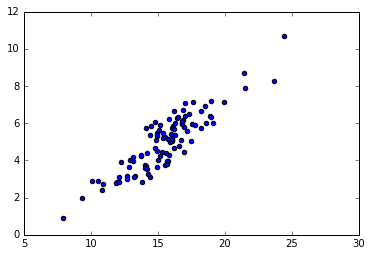

In [3]:
from bmlingam.utils.gendata import gen_artificial_data, GenDataParams

n_confounders = 1
flip = True
gen_data_params = GenDataParams(
    e1_dist=['uniform'],
    e1_std=1.0,
    e2_dist=['uniform'],
    e2_std=1.0,
    f1_coef=['r2intervals' for _ in range(n_confounders)],
    f2_coef=['r2intervals' for _ in range(n_confounders)],
    conf_dist=[['all'] for _ in range(n_confounders)],
    fix_causality=True # x1 -> x2 (b21 is non-zero)
)
n_samples = gen_data_params.n_samples
data = gen_artificial_data(gen_data_params)
print('b_true = {}'.format(data['b']))
xs = data['xs']

# Flip causal direction
if flip:
    xs = np.vstack((xs[:, 1], xs[:, 0])).T
    print('{} (flipped)'.format(data['causality_true']))
else:
    print('{} (not flipped)'.format(data['causality_true']))

plt.scatter(xs[:, 0], xs[:, 1])

# model.get_mixbml_model(

In [4]:
from model import MixBMLParams, get_mixbml_model

hparams = MixBMLParams()
print(json.dumps(hparams.as_dict(), indent=2))

{
  "standardize": true,
  "dist_scale_indvdl": "uniform, 0.01, 1.0",
  "dist_beta_noise": "uniform, 0.01, 1.0",
  "dist_noise": "laplace",
  "prior_var_mu": "auto",
  "df_indvdl": 8.0,
  "dist_std_noise": "log_normal",
  "fix_mu_zero": true,
  "subtract_mu_reg": false,
  "dist_indvdl": "t",
  "dist_beta_indvdl": "uniform, 0.1, 1.0",
  "dist_l_cov_21": "uniform, -0.9, 0.9"
}


In [5]:
from model import get_mixbml_model

with pm.Model() as model:
    get_mixbml_model(xs, hparams)
    advifit = pm.variational.advi(n=100000)
    trace = pm.variational.sample_vp(advifit)

100%|██████████| 1000/1000 [00:00<00:00, 3678.27it/s]


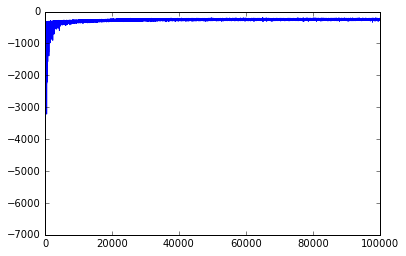

In [6]:
plt.plot(advifit.elbo_vals)

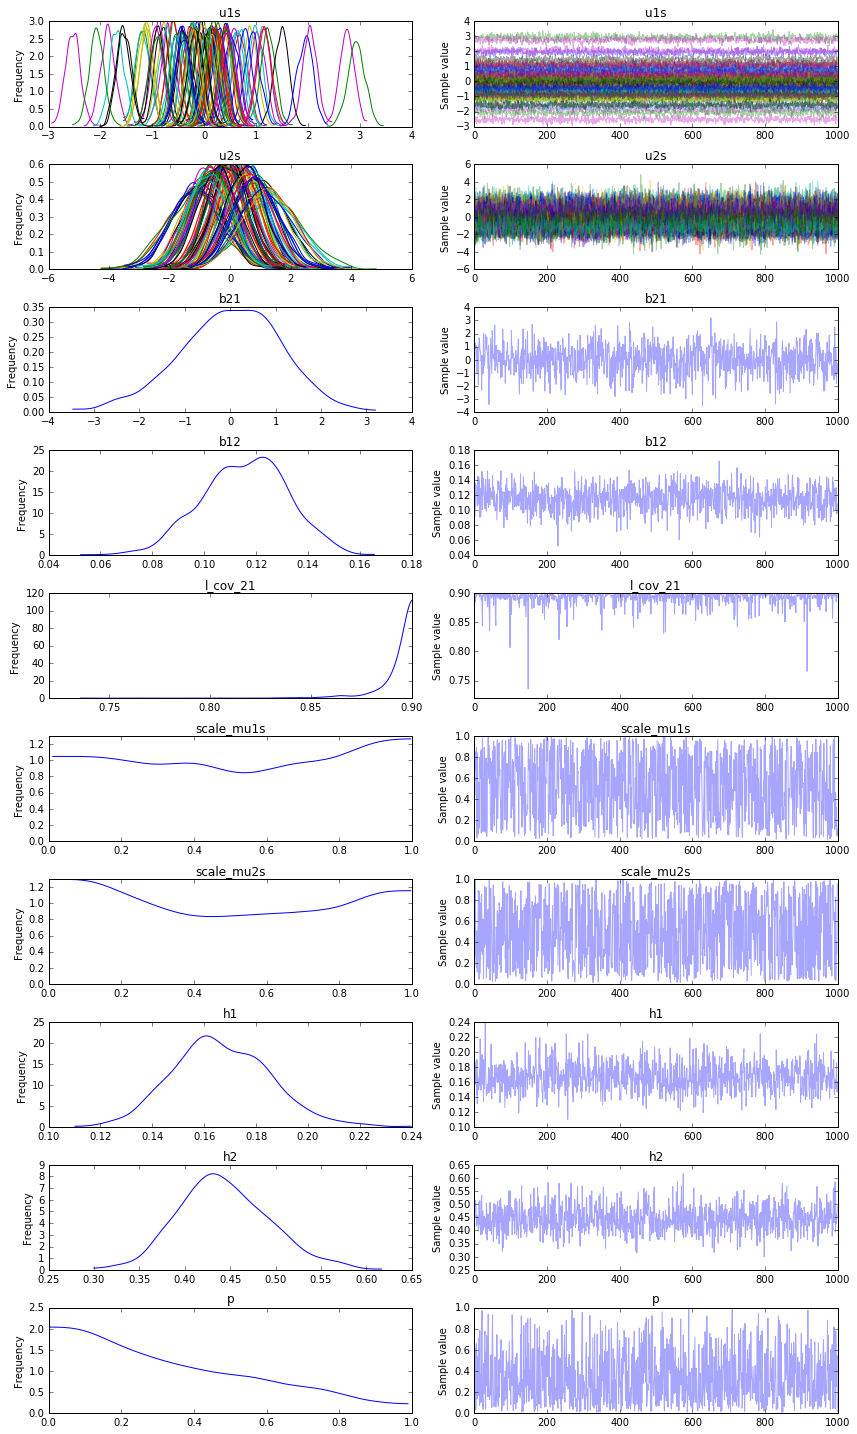

In [7]:
pm.traceplot(trace);